In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from run_templates import *
from run_cls_templates import *
from experiment_classifier import ClsModel

In [93]:
device = 'cuda:3'
conf = ffhq256_autoenc()
conf.T_eval = 100
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [49]:
cls_conf = cls_ffhq256_autoenc()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
_IncompatibleKeys(missing_keys=[], unexpected_keys=['x_T'])
loading latent stats ...
latent step: 9375


In [65]:
data = conf.make_dataset()
loader = conf.make_loader(data, shuffle=True, batch_size=1)

In [81]:
for batch in loader:
    break

In [95]:
cond = model.encode(batch['img'].to(device))
xT = model.encode_stochastic(batch['img'].to(device), cond)

In [83]:
cls_id = CelebAttrDataset.cls_to_id['Male']

In [84]:
cond2 = cls_model.normalize(cond)
cond2 = cond2 + 0.3 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)

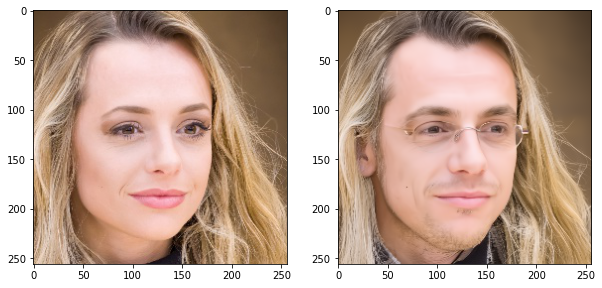

In [96]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2)
ori = (batch['img'] + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())